In [65]:
import pandas as pd
import numpy as np

In [66]:
raw_df = pd.read_csv("../concept_labeling_outputs/merged_dataset_with_concepts.csv")
window_df = pd.read_csv("../concept_labeling_outputs/merged_window_labels.csv")

In [67]:
print(raw_df.shape)
print(window_df.shape)

(8802, 10)
(150, 8)


In [ ]:
raw_df["magnitude"] = np.sqrt(raw_df["x-axis"]**2 + raw_df["y-axis"]**2 + raw_df["z-axis"]**2)

raw_df["motion_intensity"] = (raw_df["magnitude"] - raw_df["magnitude"].min()) / (raw_df["magnitude"].max() - raw_df["magnitude"].min())

x_norm = np.linalg.norm(raw_df["x-axis"])
y_norm = np.linalg.norm(raw_df["y-axis"])
z_norm = np.linalg.norm(raw_df["z-axis"])

raw_df["vertical_dominance"] = abs(raw_df["z-axis"]) / (abs(raw_df["x-axis"]) + abs(raw_df["y-axis"]) + abs(raw_df["z-axis"]) + 1e-9)

# FIXED: Static posture based on signal variance, not motion intensity
# This removes the circular dependency
def detect_static_posture(df, window_size=10):
    """
    Detect static posture based on signal variance, not motion intensity.
    This removes the circular dependency.
    """
    static_posture = np.zeros(len(df))
    
    for i in range(len(df)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(df), i + window_size // 2)
        
        # Get window of sensor data
        window_data = df.iloc[start_idx:end_idx][['x-axis', 'y-axis', 'z-axis']].values
        
        # Calculate signal variance (not magnitude-based)
        signal_variance = np.var(window_data, axis=0).mean()
        
        # Static if variance is very low (indicating minimal movement)
        static_posture[i] = 1.0 if signal_variance < 0.5 else 0.0
    
    return static_posture

# Apply static posture detection based on variance
raw_df["static_posture"] = detect_static_posture(raw_df)

# Define contextual relationships - which features should use static posture contextually
def get_contextual_features_config():
    """
    Define which features should use static posture contextually.
    This configuration determines how static posture influences other motion concepts.
    """
    contextual_config = {
        'motion_intensity': True,    # Uses static posture context - helps distinguish low motion vs transitions
        'vertical_dominance': True,  # Uses static posture context - static periods affect vertical dominance interpretation
        'periodicity': False,       # Independent - periodic patterns don't depend on static posture
        'temporal_stability': False, # Independent - temporal stability is about consistency, not static periods
        'coordination': False        # Independent - coordination is about limb synchronization, not static posture
    }
    return contextual_config

# Get the contextual configuration
contextual_config = get_contextual_features_config()
print("Contextual Features Configuration:")
for feature, uses_context in contextual_config.items():
    print(f"  {feature}: {'Uses static posture context' if uses_context else 'Independent'}")

def compute_window_features(df, start, end):
    segment = df[(df["time_s"] >= start) & (df["time_s"] <= end)]
    if len(segment) == 0:
        return pd.Series({"motion_intensity": np.nan, "vertical_dominance": np.nan, "static_posture": np.nan, "magnitude": np.nan})
    
    # Calculate motion intensity (independent of static posture)
    mag = np.sqrt(segment["x-axis"]**2 + segment["y-axis"]**2 + segment["z-axis"]**2)
    motion_intensity = (mag.mean() - raw_df["magnitude"].min()) / (raw_df["magnitude"].max() - raw_df["magnitude"].min())
    
    # Calculate vertical dominance (independent of static posture)
    vert_dom = np.linalg.norm(segment["z-axis"]) / (
        np.linalg.norm(segment["x-axis"]) + np.linalg.norm(segment["y-axis"]) + np.linalg.norm(segment["z-axis"]) + 1e-9
    )
    
    # FIXED: Static posture based on signal variance, not motion intensity
    signal_variance = np.var(segment[['x-axis', 'y-axis', 'z-axis']].values, axis=0).mean()
    static_posture = 1.0 if signal_variance < 0.5 else 0.0
    
    magnitude_mean = mag.mean()
    return pd.Series({
        "motion_intensity": motion_intensity,
        "vertical_dominance": vert_dom,
        "static_posture": static_posture,
        "magnitude": magnitude_mean
    })

window_features = window_df.apply(lambda row: compute_window_features(raw_df, row["start_time"], row["end_time"]), axis=1)
window_df = pd.concat([window_df, window_features], axis=1)

raw_df.drop(columns=["magnitude"], inplace=True)
window_df.drop(columns=["magnitude"], inplace=True)

# Save the contextual configuration with the data
import json
with open("contextual_config.json", "w") as f:
    json.dump(contextual_config, f, indent=2)

raw_df.to_csv("raw_with_features.csv", index=False)
window_df.to_csv("window_with_features.csv", index=False)

print(f"\nFIXED: Static posture now based on signal variance, not motion intensity")
print(f"Raw data static posture rate: {raw_df['static_posture'].mean():.3f}")
print(f"Window data static posture rate: {window_df['static_posture'].mean():.3f}")

In [69]:
print(raw_df[["motion_intensity", "vertical_dominance", "static_posture"]].describe())
print(window_df[["motion_intensity", "vertical_dominance", "static_posture"]].describe())

print(raw_df.shape)
print(window_df.shape)

       motion_intensity  vertical_dominance  static_posture
count       8802.000000         8802.000000     8802.000000
mean           0.331265            0.243082        0.032947
std            0.146701            0.213129        0.178508
min            0.000000            0.000000        0.000000
25%            0.270740            0.084025        0.000000
50%            0.295913            0.177345        0.000000
75%            0.387405            0.358235        0.000000
max            1.000000            0.916763        1.000000
       motion_intensity  vertical_dominance  static_posture
count        150.000000          150.000000           150.0
mean           0.331157            0.248287             0.0
std            0.041124            0.080944             0.0
min            0.277237            0.041401             0.0
25%            0.304296            0.201228             0.0
50%            0.316702            0.236932             0.0
75%            0.338431            0.291

In [70]:
print(raw_df.head())
print(window_df.head())

   user activity        timestamp  x-axis  y-axis  z-axis      time_s  \
0     3  Walking  101790131507000    1.76    0.46   -1.61  957.780029   
1     3  Walking  101790211616000    0.57    1.50   -2.30  957.860138   
2     3  Walking  101790251594000    2.56    5.48    5.52  957.900116   
3     3  Walking  101790291480000   11.73   14.90   17.08  957.940002   
4     3  Walking  101790331550000    9.43    5.01    3.60  957.980072   

   periodicity  temporal_stability  coordination  motion_intensity  \
0          1.0                 0.5           0.5          0.063145   
1          1.0                 0.5           0.5          0.075010   
2          1.0                 0.5           0.5          0.245287   
3          1.0                 0.5           0.5          0.793429   
4          1.0                 0.5           0.5          0.342695   

   vertical_dominance  static_posture  
0            0.420366             1.0  
1            0.526316             1.0  
2            0.40708

Static Posture Distribution:
Raw data:
static_posture
0.0    8512
1.0     290
Name: count, dtype: int64

Raw data - Static posture rate: 0.033

Window data:
static_posture
0.0    150
Name: count, dtype: int64
Window data - Static posture rate: 0.000


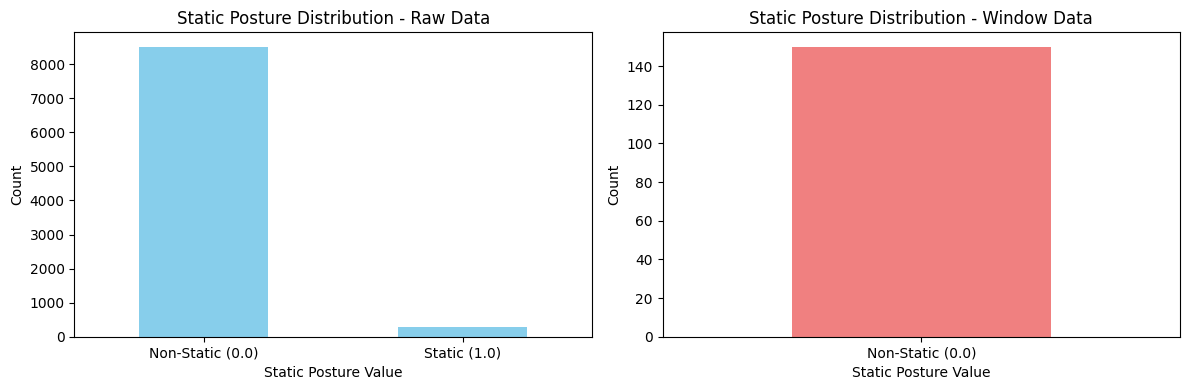

In [71]:
# Check static posture distribution
print("Static Posture Distribution:")
print("Raw data:")
print(raw_df['static_posture'].value_counts().sort_index())
print(f"\nRaw data - Static posture rate: {raw_df['static_posture'].mean():.3f}")

print("\nWindow data:")
print(window_df['static_posture'].value_counts().sort_index())
print(f"Window data - Static posture rate: {window_df['static_posture'].mean():.3f}")

# Visualize the distribution
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Raw data distribution
raw_counts = raw_df['static_posture'].value_counts().sort_index()
raw_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Static Posture Distribution - Raw Data')
ax1.set_xlabel('Static Posture Value')
ax1.set_ylabel('Count')
# Set labels based on actual values present
raw_labels = ['Non-Static (0.0)' if 0.0 in raw_counts.index else '', 
              'Static (1.0)' if 1.0 in raw_counts.index else '']
raw_labels = [label for label in raw_labels if label]  # Remove empty labels
ax1.set_xticklabels(raw_labels, rotation=0)

# Window data distribution
window_counts = window_df['static_posture'].value_counts().sort_index()
window_counts.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Static Posture Distribution - Window Data')
ax2.set_xlabel('Static Posture Value')
ax2.set_ylabel('Count')
# Set labels based on actual values present
window_labels = ['Non-Static (0.0)' if 0.0 in window_counts.index else '', 
                 'Static (1.0)' if 1.0 in window_counts.index else '']
window_labels = [label for label in window_labels if label]  # Remove empty labels
ax2.set_xticklabels(window_labels, rotation=0)

plt.tight_layout()
plt.show()
